In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


In [3]:
df = pd.read_csv("./dataset/heart_clean.csv")

X = df.drop("target", axis=1)
y = df["target"]

print("Full dataset shape:", df.shape)


Full dataset shape: (303, 14)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", x_train.shape)
print("y_train:", y_train.shape)
print("X_test :", x_test.shape)
print("y_test :", y_test.shape)


X_train: (242, 13)
y_train: (242,)
X_test : (61, 13)
y_test : (61,)


In [5]:
x_train_np = x_train.to_numpy()
x_test_np = x_test.to_numpy()

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

print("X_train_np:", x_train_np.shape)
print("y_train_np:", y_train_np.shape)


X_train_np: (242, 13)
y_train_np: (242,)


In [6]:
def inject_gaussian_noise(X, noise_level, random_state=42):
    rng = np.random.RandomState(random_state)
    noise = rng.normal(
        loc=0.0,
        scale=noise_level,
        size=X.shape
    )
    return X + noise


In [7]:
noise_levels = [0.05, 0.10, 0.20]

results = []

for noise in noise_levels:
    
    # 1️⃣ Inject noise ONLY into training data
    x_train_noisy = inject_gaussian_noise(
        x_train_np,
        noise_level=noise,
        random_state=42
    )
    
    # 2️⃣ Scale
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_noisy)
    x_test_scaled = scaler.transform(x_test_np)
    
    # 🔒 Hard safety check
    assert x_train_scaled.shape[0] == y_train_np.shape[0]
    
    print(f"\nNoise level: {noise}")
    print("X_train_scaled:", x_train_scaled.shape)
    print("y_train_np:", y_train_np.shape)
    
    # 3️⃣ Train model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(x_train_scaled, y_train_np)
    
    # 4️⃣ Evaluate
    y_pred = model.predict(x_test_scaled)
    y_prob = model.predict_proba(x_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_np, y_pred)
    f1 = f1_score(y_test_np, y_pred)
    auc = roc_auc_score(y_test_np, y_prob)
    
    results.append({
        "noise_level": noise,
        "accuracy": acc,
        "f1_score": f1,
        "roc_auc": auc,
        "model": model,
        "scaler": scaler
    })



Noise level: 0.05
X_train_scaled: (242, 13)
y_train_np: (242,)

Noise level: 0.1
X_train_scaled: (242, 13)
y_train_np: (242,)

Noise level: 0.2
X_train_scaled: (242, 13)
y_train_np: (242,)


In [ ]:
results_df = pd.DataFrame(results)[
    ["noise_level", "accuracy", "f1_score", "roc_auc"]
]

results_df


results_df.to_csv(
    "./results/lr_noise_performance.csv",
    index=False
)

print("Saved: lr_noise_performance.csv")


Saved: lr_noise_performance.csv


In [ ]:
#Instance based Test

instance_idx = 0

import shap
import matplotlib.pyplot as plt



# Scale test data using baseline scaler
x_test_scaled_clean = scaler.transform(x_test_np)

def predict_clean(X):
    return model.predict_proba(X)[:, 1]

# Background for Kernel SHAP
background = shap.sample(
    scaler.transform(x_train_scaled),
    50,
    random_state=42
)

explainer_clean = shap.KernelExplainer(
    predict_clean,
    background
)

shap_values_clean = explainer_clean.shap_values(x_test_scaled_clean)


100%|██████████| 61/61 [00:05<00:00, 11.14it/s]


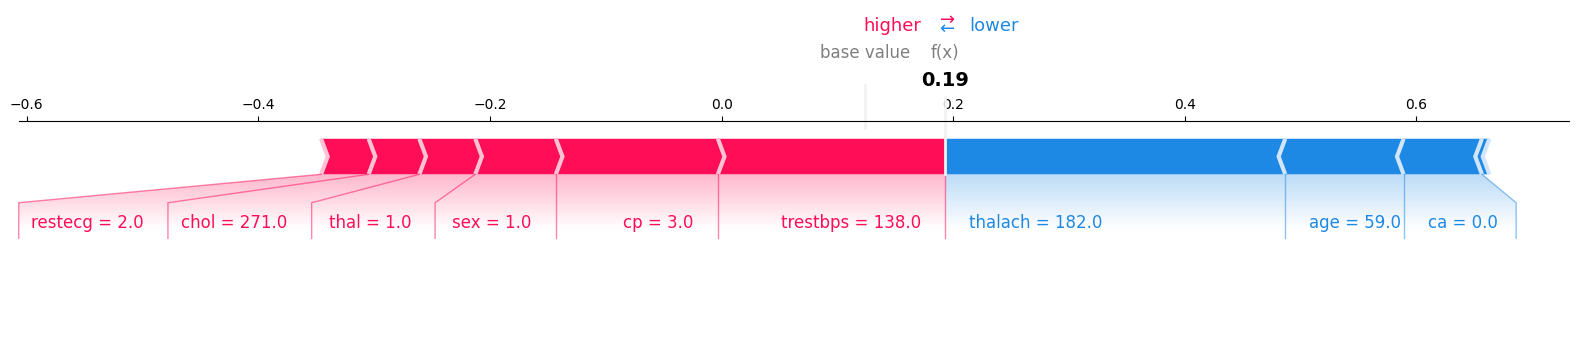

In [11]:
shap.force_plot(
    explainer_clean.expected_value,
    shap_values_clean[instance_idx],
    x_test.iloc[instance_idx],
    matplotlib=True
)


In [15]:
# Select degraded model (noise = 0.20)
degraded_entry = [r for r in results if r["noise_level"] == 0.20][0]

degraded_model = degraded_entry["model"]
degraded_scaler = degraded_entry["scaler"]

x_test_scaled_noisy = degraded_scaler.transform(x_test_np)

def predict_noisy(X):
    return degraded_model.predict_proba(X)[:, 1]


In [16]:
explainer_noisy = shap.KernelExplainer(
    predict_noisy,
    background
)

shap_values_noisy = explainer_noisy.shap_values(x_test_scaled_noisy)


100%|██████████| 61/61 [00:05<00:00, 10.67it/s]


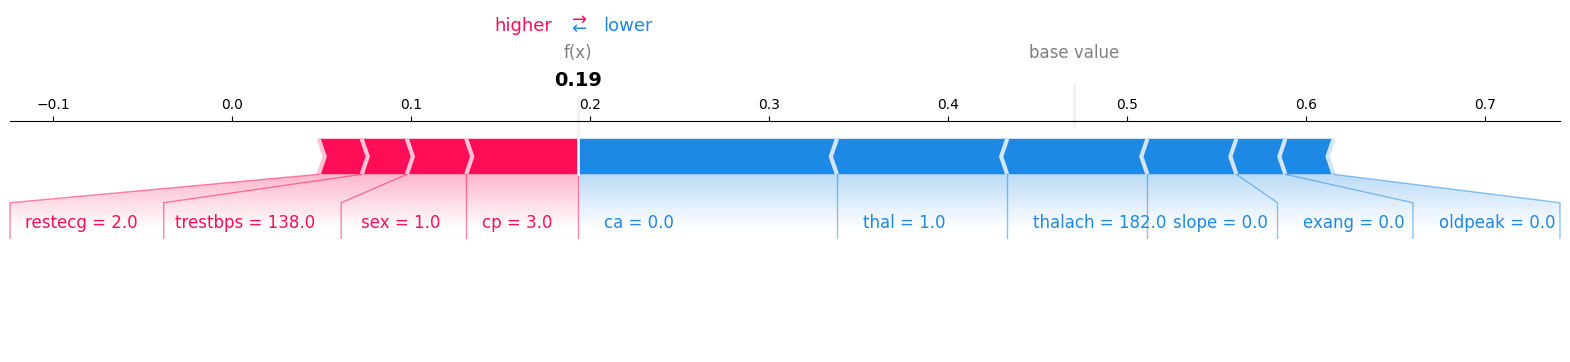

In [ ]:
shap.force_plot(
    explainer_noisy.expected_value,
    shap_values_noisy[instance_idx],
    x_test.iloc[instance_idx],
    matplotlib=True
)
